In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma, invgamma, t, norm, norminvgauss, mode, multivariate_normal, uniform
from scipy.special import loggamma
import emcee
import corner

In [11]:
# read the supernova (cosmological) redshift data
datafile = open('SCPUnion2.1_mu_vs_z.txt','r')
SCP_data = pd.read_table(datafile,comment='#',
                        names=['SN name','Redshift','Distance modulus',
                                   'Distance modulus error','P low mass'])
alpha = 0.121851859725
beta = 2.46569277393
delta = -0.0363405630486
print(SCP_data)

    SN name  Redshift  Distance modulus  Distance modulus error  P low mass
0    1993ah  0.028488         35.346583                0.223906    0.128419
1    1993ag  0.050043         36.682368                0.166829    0.128419
2     1993o  0.052926         36.817691                0.155756    0.128419
3     1993b  0.070086         37.446737                0.158467    0.128419
4    1992bs  0.062668         37.483409                0.156099    0.128419
..      ...       ...               ...                     ...         ...
575   D-000  1.017000         44.293971                0.171046    0.000015
576   D-006  1.315000         44.971358                0.187509    0.551672
577   P-009  0.821000         43.640939                0.194014    0.551672
578   R-012  1.215000         45.246521                0.560317    0.000148
579   Z-005  0.623000         42.514524                0.241428    0.551672

[580 rows x 5 columns]


In [89]:
filename = 'SCPUnion2.1_mu_vs_z.txt'

# Load the data from the file
data = np.loadtxt(filename, usecols=(1, 2, 3, 4), skiprows = 5)

z = data[:, 0] # size: 580x1
low = z < 0.5
mu = data[:, 1]
mu_error = data[:, 2]
P_low_mass = data[:, 3]
dl = 10**(mu/5-5)
#dl_error = dl*mu_error/5
dl_error = 10**(mu/5-5)*(10**(mu_error/5) - 1)

low_z = z[low] # size: 412x1
low_mu = mu[low]
low_mu_error = mu_error[low]
low_P_low_mass = P_low_mass[low]
low_dl = 10**(low_mu/5-5)
#find correct expression
#low_dl_error = 10**(low_mu_error/5-5)
low_dl_error = dl_error[low]

In [91]:
def log_likelihood(theta, phi, data, weights, error_scale):
    mat = np.matmul(phi,theta)-data
    return -0.5*np.matmul(np.matmul(np.transpose(mat), weights),mat)/error_scale

def log_prior(theta):
    #uniform prior
    return 0
def log_posterior(theta, phi, data, weights, error_scale):
    ll = log_likelihood(theta, phi, data, weights, error_scale)
    lp = log_prior(theta)
    return ll + lp


In [95]:
low_phi = np.transpose(np.array([low_z, low_z**2]))
weights = np.diag(1/low_dl_error)
error_scale = beta/(alpha+1)

nwalkers = 20
ndim = 2
start = np.random.randn(nwalkers,ndim) + 1000
print(start.shape)
print(low_phi.shape)
print(weights.shape)
#print((low_phi*start).shape)

#res = log_likelihood(start, low_phi, low_dl, weights, error_scale)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(low_phi, low_dl, weights, error_scale))
sampler.run_mcmc(start, 2000, progress=True)

(20, 2)
(412, 2)
(412, 412)


  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:05<00:00, 342.38it/s]


State([[4306.21203513 2987.39093273]
 [4318.23121911 2944.41013255]
 [4308.75253666 2985.12771606]
 [4310.36153485 2976.45516171]
 [4303.28078115 2988.0320748 ]
 [4314.6067842  2966.4150261 ]
 [4303.52157013 3012.43267149]
 [4308.99231806 2981.91627279]
 [4313.93716527 2965.51547414]
 [4302.53054786 2992.26755764]
 [4308.01006016 2989.01521955]
 [4302.61311468 2995.71182352]
 [4302.00505846 2994.99816719]
 [4301.44244749 3013.99855597]
 [4311.85924672 2983.58489692]
 [4295.21699227 3028.86215586]
 [4304.10654843 2995.91983363]
 [4300.55247378 2989.51734191]
 [4304.8244311  2999.0158931 ]
 [4305.10902065 2985.36120209]], log_prob=[-17937.65669013 -17940.16999511 -17937.82520093 -17937.81225538
 -17938.51046445 -17938.57545483 -17939.9133575  -17937.72162741
 -17938.3716964  -17938.33768745 -17937.93169615 -17938.01639151
 -17938.28858971 -17939.17707221 -17939.11654942 -17940.25609428
 -17937.77580828 -17940.23647367 -17938.0486101  -17938.0184036 ], blobs=None, random_state=('MT19937',

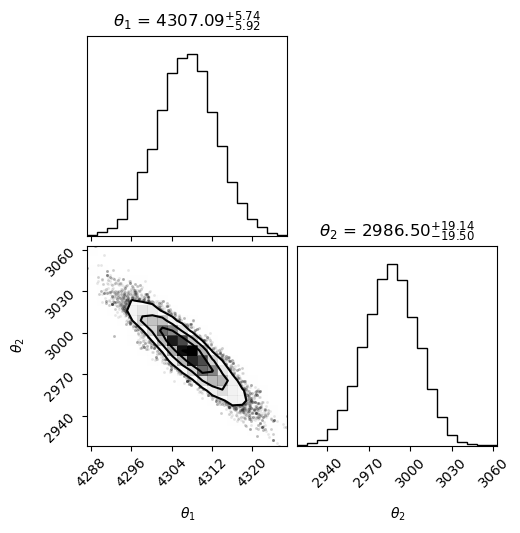

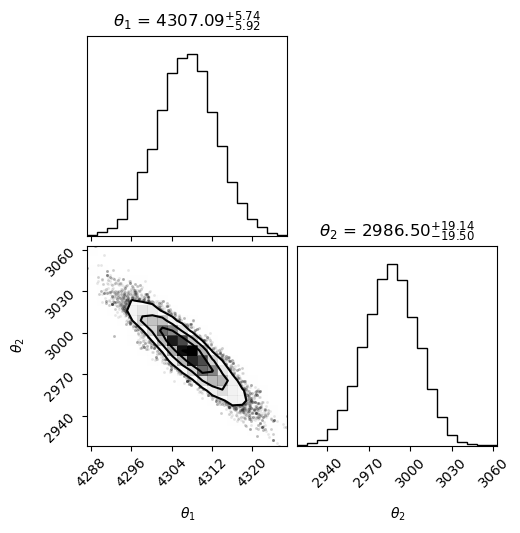

In [96]:
burn_in = 1000
flat_mcmc_samples = sampler.get_chain(discard=burn_in, flat=True)
corner.corner(flat_mcmc_samples, labels = [r"$\theta_1$", r"$\theta_2$"], show_titles = True)

In [97]:
print(flat_mcmc_samples.shape)
c = 300000 #km/s
theta_1 = flat_mcmc_samples[:,0]
theta_2 = flat_mcmc_samples[:,1]
H_0 = c/theta_1
q_0 = 1-2*theta_2/c
print(f"H_0 = {np.mean(H_0)}\n q_0 = {np.mean(q_0)}")

(20000, 2)
H_0 = 69.6537443230433
 q_0 = 0.9800912160328842


223.04766143638113
222.91803061796102
223.1788103450534


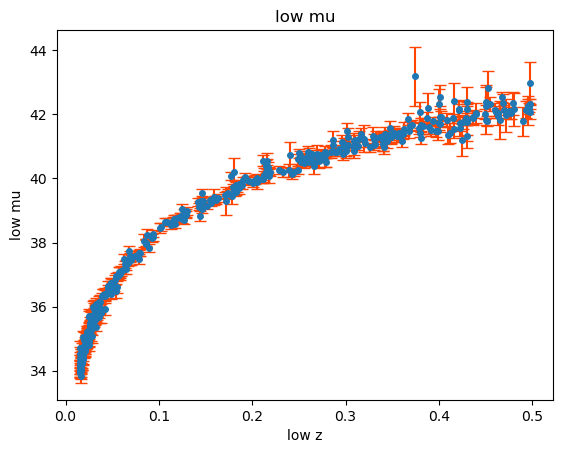

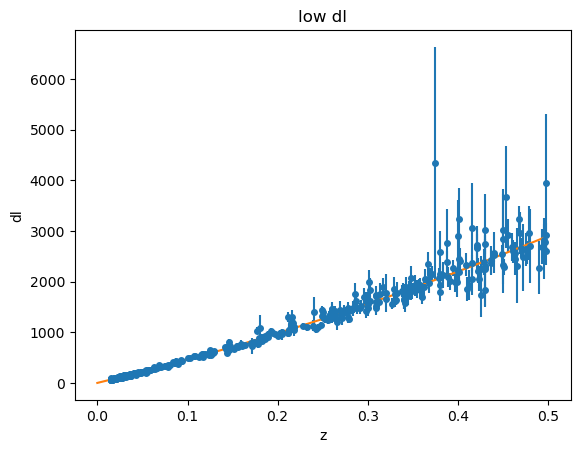

In [98]:
z_lin = np.linspace(0,0.5, 1000)
res_d = np.empty(1000)
res_d_min = np.empty(1000)
res_d_max = np.empty(1000)
for i,z in enumerate(z_lin):
    vec = theta_1 * z + theta_2 * z**2
    res_d[i] = np.mean(vec)
    res_d_min[i] = np.percentile(vec, 30)
    res_d_max[i] = np.percentile(vec,70)

print(res_d[100])
print(res_d_min[100])
print(res_d_max[100])

plt.figure(1)
plt.errorbar(low_z, low_mu, yerr=low_mu_error, fmt='o', ecolor='orangered', capsize=4, linestyle='None', markersize=4)
plt.xlabel('low z')
plt.ylabel('low mu')
plt.title('low mu')

# Display the first figure
plt.show()

# Create the second figure with error bars
plt.figure(2)
plt.errorbar(low_z, low_dl, yerr = low_dl_error, fmt = 'o', markersize=4)
plt.plot(z_lin, res_d)
plt.fill_between(z_lin, res_d_min, res_d_max, alpha = 0.4)
plt.xlabel('z')
plt.ylabel('dl')
plt.title('low dl')

# Display the second figure
plt.show()